In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [7]:
import joblib

In [8]:
from sklearn.metrics import classification_report

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [9]:
data = pd.read_csv("final_features.csv", nrows=100000)

In [10]:
print(data.shape)
data.head()

(100000, 221)


,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,23.793560,-20.588538,-25.390728,12.380474,-19.671300,16.618838,30.438979,43.384339,5.521896,2.243536
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,68.032528,1.352752,-25.395078,-7.580498,-23.430201,3.710806,1.435839,44.218947,11.410592,22.943373
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,-10.696379,-35.324791,-20.233565,40.031800,-22.515539,12.892510,0.084740,21.583779,24.523905,-7.576786
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,6.891580,-21.247972,0.394724,41.386917,-9.613216,18.265161,-1.723291,1.429064,18.121417,18.179006
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,17.671461,-11.538394,-11.433049,14.088319,-32.659020,6.244056,20.535059,17.647714,12.484857,-12.859808


In [11]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [13]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,68.032528,1.352752,-25.395078,-7.580498,-23.430201,3.710806,1.435839,44.218947,11.410592,22.943373
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,-10.696379,-35.324791,-20.233565,40.031800,-22.515539,12.892510,0.084740,21.583779,24.523905,-7.576786
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,6.891580,-21.247972,0.394724,41.386917,-9.613216,18.265161,-1.723291,1.429064,18.121417,18.179006
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,17.671461,-11.538394,-11.433049,14.088319,-32.659020,6.244056,20.535059,17.647714,12.484857,-12.859808
5,0.666656,0.571420,0.888879,0.799992,0.705878,0.705878,1.0,0.0,0.0,17.0,...,23.299828,23.817801,-24.890131,-56.927054,-2.215075,52.634251,-14.493708,22.898442,-15.336361,47.136550


In [72]:
data.columns[:26]

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

<h2> 4.2 Random train test split( 70:30) </h2>

In [14]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [15]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (69999, 218)
Number of data points in test data : (30000, 218)


In [16]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274518207402963 Class 1:  0.3725481792597037
---------- Distribution of output variable in train data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


In [17]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.3 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.88292022272887


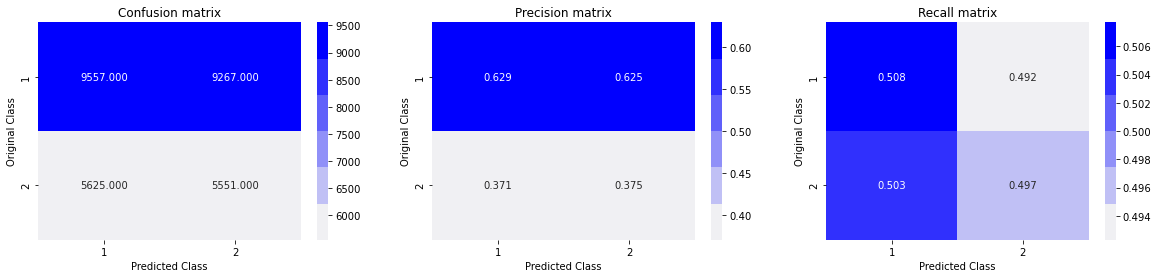

In [18]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.44405267415566646
For values of alpha =  0.0001 The log loss is: 0.4398019452246458
For values of alpha =  0.001 The log loss is: 0.44988409745769337
For values of alpha =  0.01 The log loss is: 0.42916637569165056
For values of alpha =  0.1 The log loss is: 0.4382987539891762
For values of alpha =  1 The log loss is: 0.4736510784816674
For values of alpha =  10 The log loss is: 0.5226600863664517


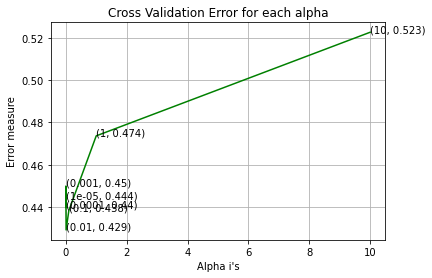

For values of best alpha =  0.01 The train log loss is: 0.427208432249808
For values of best alpha =  0.01 The test log loss is: 0.42916637569165056
Total number of data points : 30000


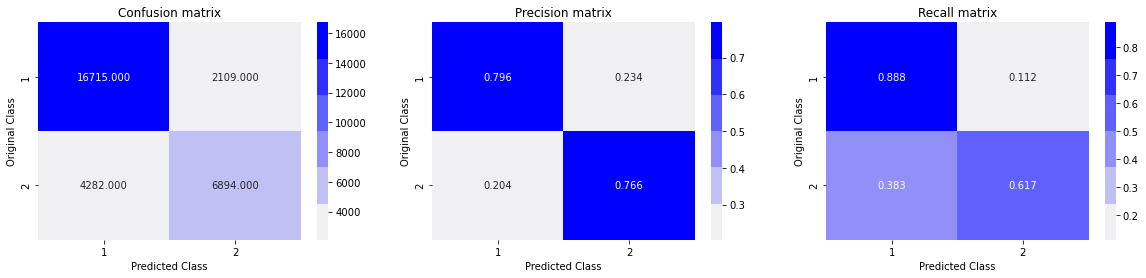

In [19]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [20]:
joblib.dump(sig_clf, "logistic_regression.pkl")

['logistic_regression.pkl']

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4395748866847715
For values of alpha =  0.0001 The log loss is: 0.46331612902160474
For values of alpha =  0.001 The log loss is: 0.5109438064184811
For values of alpha =  0.01 The log loss is: 0.5051985896685232
For values of alpha =  0.1 The log loss is: 0.5381589284293178
For values of alpha =  1 The log loss is: 0.5802091855276253
For values of alpha =  10 The log loss is: 0.6602902104879251


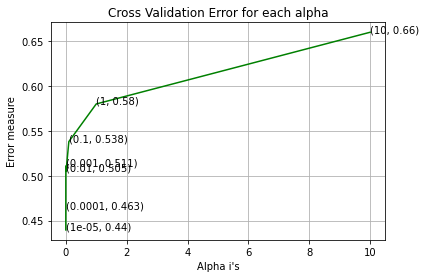

For values of best alpha =  1e-05 The train log loss is: 0.4372461574182881
For values of best alpha =  1e-05 The test log loss is: 0.4395748866847715
Total number of data points : 30000


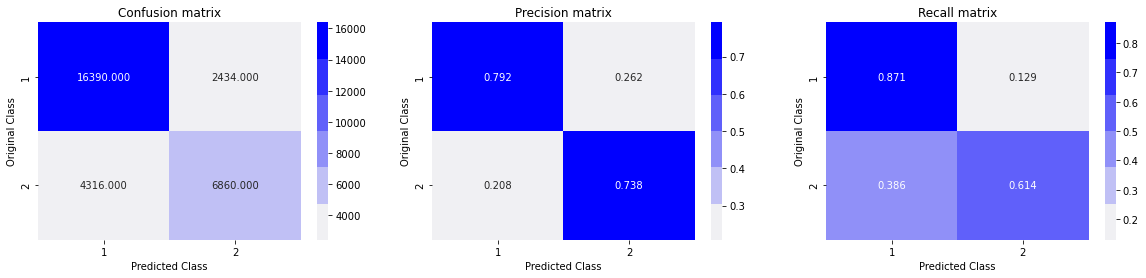

In [21]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [22]:
joblib.dump(sig_clf, "linear_svm.pkl")

['linear_svm.pkl']

<h2> 4.6 XGBoost </h2>

In [23]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

[0]	train-logloss:0.68479	valid-logloss:0.68497
[10]	train-logloss:0.61525	valid-logloss:0.61669
[20]	train-logloss:0.56398	valid-logloss:0.56635
[30]	train-logloss:0.52578	valid-logloss:0.52884
[40]	train-logloss:0.49663	valid-logloss:0.50022
[50]	train-logloss:0.47376	valid-logloss:0.47769
[60]	train-logloss:0.45575	valid-logloss:0.45989
[70]	train-logloss:0.44101	valid-logloss:0.44539
[80]	train-logloss:0.42918	valid-logloss:0.43372
[90]	train-logloss:0.41946	valid-logloss:0.42423
[100]	train-logloss:0.41162	valid-logloss:0.41660
[110]	train-logloss:0.40483	valid-logloss:0.41001
[120]	train-logloss:0.39921	valid-logloss:0.40456
[130]	train-logloss:0.39432	valid-logloss:0.39980
[140]	train-logloss:0.38997	valid-logloss:0.39565
[150]	train-logloss:0.38628	valid-logloss:0.39217
[160]	train-logloss:0.38322	valid-logloss:0.38940
[170]	train-logloss:0.38038	valid-logloss:0.38677
[180]	train-logloss:0.37788	valid-logloss:0.38448
[190]	train-logloss:0.37563	valid-logloss:0.38249
[200]	train

Total number of data points : 30000


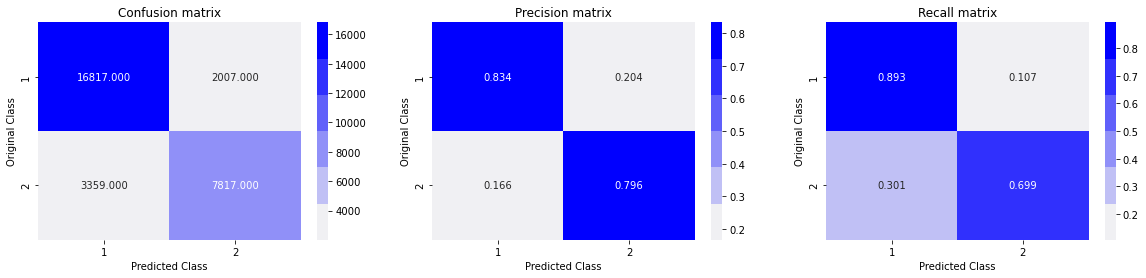

In [24]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [73]:
joblib.dump(bst, "xgboost_naive.pkl")

['xgboost_naive.pkl']

<h3>Decision Tree (Extra)</h3>

In [25]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=42)
params = {
    "criterion" : ["gini", "entropy"],
    "max_depth" : [1,2,3,4,5,6,7,None]
}

In [26]:
from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(decision_tree, params, cv=10, random_state=42)

In [28]:
search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7,
                                                      None]},
                   random_state=42)

In [29]:
print("Best estimator is-")
print(search.best_estimator_)
print("Best parameters are-")
print(search.best_params_)

Best estimator is-
DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)
Best parameters are-
{'max_depth': 7, 'criterion': 'entropy'}


In [30]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)

In [31]:
y_pred_proba = decision_tree.predict_proba(X_test)
y_pred = decision_tree.predict(X_test)

In [32]:
print(log_loss(y_test, y_pred_proba, eps=1e-5))

0.41012045975584843


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85     18824
           1       0.80      0.61      0.69     11176

    accuracy                           0.80     30000
   macro avg       0.80      0.76      0.77     30000
weighted avg       0.80      0.80      0.79     30000



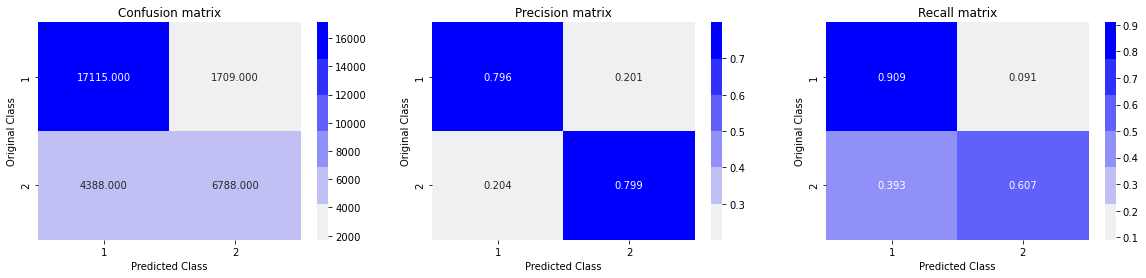

In [34]:
plot_confusion_matrix(y_test, y_pred)

In [35]:
joblib.dump(decision_tree, "decision_tree.pkl")

['decision_tree.pkl']

<h3>Random Forest (Extra)</h3>

In [36]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(random_state=42)
params = {
    "n_estimators" : [20,40,60,80,100],
    "criterion" : ["gini", "entropy"],
    "max_depth" : [1,2,3,4,5,6,7,None],

}

In [37]:
search = RandomizedSearchCV(random_forest, params, cv=10, random_state=42, verbose=10)

In [38]:
search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START criterion=gini, max_depth=7, n_estimators=20..............
[CV 1/10; 1/10] END criterion=gini, max_depth=7, n_estimators=20;, score=0.796 total time=  15.9s
[CV 2/10; 1/10] START criterion=gini, max_depth=7, n_estimators=20..............
[CV 2/10; 1/10] END criterion=gini, max_depth=7, n_estimators=20;, score=0.801 total time=  14.5s
[CV 3/10; 1/10] START criterion=gini, max_depth=7, n_estimators=20..............
[CV 3/10; 1/10] END criterion=gini, max_depth=7, n_estimators=20;, score=0.795 total time=  14.7s
[CV 4/10; 1/10] START criterion=gini, max_depth=7, n_estimators=20..............
[CV 4/10; 1/10] END criterion=gini, max_depth=7, n_estimators=20;, score=0.797 total time=  15.0s
[CV 5/10; 1/10] START criterion=gini, max_depth=7, n_estimators=20..............
[CV 5/10; 1/10] END criterion=gini, max_depth=7, n_estimators=20;, score=0.795 total time=  16.9s
[CV 6/10; 1/10] START criterion=gini, max_

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7,
                                                      None],
                                        'n_estimators': [20, 40, 60, 80, 100]},
                   random_state=42, verbose=10)

In [39]:
print("Best estimator is-")
print(search.best_estimator_)
print("Best parameters are-")
print(search.best_params_)

Best estimator is-
RandomForestClassifier(max_depth=7, n_estimators=40, random_state=42)
Best parameters are-
{'n_estimators': 40, 'max_depth': 7, 'criterion': 'gini'}


In [40]:
random_forest = RandomForestClassifier(n_estimators= 40, max_depth= 7, criterion= 'gini')
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=40)

In [41]:
y_pred_proba = random_forest.predict_proba(X_test)

In [42]:
print(log_loss(y_test, y_pred_proba, labels=[0,1], eps=1e-5))

0.4302439474149395


In [43]:
y_pred = random_forest.predict(X_test)

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     18824
           1       0.76      0.66      0.71     11176

    accuracy                           0.80     30000
   macro avg       0.79      0.77      0.78     30000
weighted avg       0.79      0.80      0.79     30000



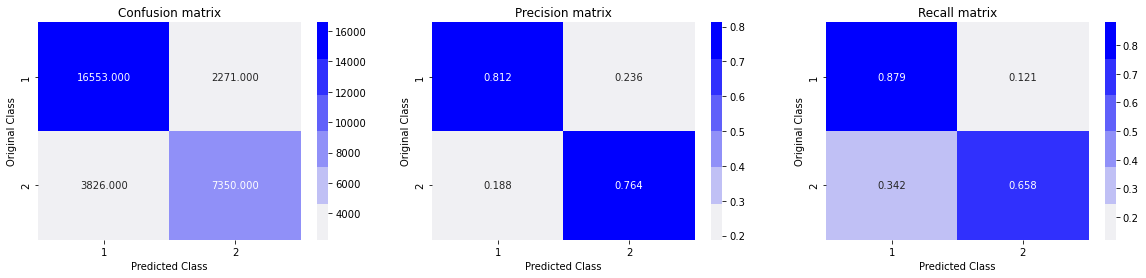

In [45]:
plot_confusion_matrix(y_test, y_pred)

In [46]:
joblib.dump(random_forest, "random_forest.pkl")

['random_forest.pkl']

<h1> 5. Assignments </h1>

Perform hyperparameter tuning  of XgBoost models using RandomsearchCV/GridSearchCV with vectorizer as TF-IDF W2V  to reduce the log-loss.

In [47]:
xgb.XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [78]:
my_model = xgb.XGBClassifier(
    eval_metric = "logloss",
    objective = "binary:logistic",
    n_estimators = 400,
    max_depth = 14,
    subsample = 0.4,
    colsample_bylevel = 0.4,
    colsample_bytree = 0.4,
    min_child_weight = 4,
    eta = 0.02,
    early_stopping_rounds = 20,
    verbosity = 3
)

In [79]:
my_model.fit(X_train, y_train)

[22:25:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:25:00] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:155: Using tree method: 2
[22:25:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 920 extra nodes, 0 pruned nodes, max_depth=14
[22:25:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 868 extra nodes, 0 pruned nodes, max_depth=14
[22:25:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
              colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=20, enable_categorical=False, eta=0.02,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0199999996,
              max_delta_step=0, max_depth=14, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
              tree_method='exact', validate_parameters=1, ...)

In [81]:
y_pred_proba = my_model.predict_proba(X_test)
print(log_loss(y_test, y_pred_proba, labels=[0, 1], eps=1e-5))

0.333513666402143


In [82]:
y_pred = my_model.predict(X_test)

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87     18824
           1       0.80      0.75      0.77     11176

    accuracy                           0.84     30000
   macro avg       0.83      0.82      0.82     30000
weighted avg       0.83      0.84      0.84     30000



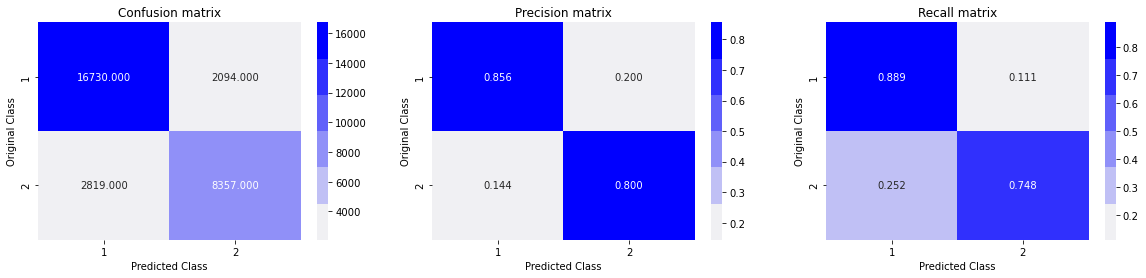

In [84]:
plot_confusion_matrix(y_test, y_pred)

In [85]:
joblib.dump(my_model, "xgboost_v1.pkl")

['xgboost_v1.pkl']